In [1]:
import sys

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    sys.path.append('/content/gdrive/MyDrive/abm')
    data_dir       = '/content/gdrive/MyDrive/abm/data/'
    figure_dir     = '/content/gdrive/MyDrive/abm/figures/'
    ! pip install mesa seaborn tqdm matplotlib gpy --quiet
else:
    data_dir    = '../data/'
    figure_dir  = '../figures/'

In [2]:
import arviz as az
import numpy as np
import pandas as pd
import pickle

from abmlib import *
from emulators import *
from itertools import product
from string import ascii_lowercase as letters

import matplotlib.pyplot as plt

In [3]:
def mv_einstein(matrices, y):
    '''
    Use Einstein summation convention to iteratively
    contract along secondary axes and implement Kronecker 
    matrix-vector product
    '''
    p = len(matrices)
    
    if p > 13:
        raise ValueError('There aren\'t enough letters in the alphabet for this operation :(')
    
    letter_pairs = [letters[2*i]+letters[2*i+1] for i in range(p)]
    matrix_string = ','.join(letter_pairs)
    vec_in_string, vec_out_string = [''.join(s) for s in zip(*letter_pairs)]
    string_spec = f'{matrix_string},{vec_in_string}->{vec_out_string}'
    
    return np.einsum(string_spec, *matrices, y, optimize='greedy'), string_spec

# Preprocessing the data

In [39]:
data = {
    'sir':{}
}

# If we don't want to load all the blocks into memory, use this to thin out some of the series
sir_thin_factor = 1

# Specify parameters that are not held constant over different
# ABM runs
sir_params_varying = [
    'ptrans',
    'death_rate',
    'pcure',
    'p_infected_initial_log10',
    'pdoctor_log10'
]

data['sir']['params'] = pd.DataFrame(pickle.load(open(data_dir + f'/sir/input_dicts.pkl','rb')))
data['sir']['params'] = data['sir']['params'][sir_params_varying].iloc[::sir_thin_factor].values
data['sir']['params_std'] = data['sir']['params'] / data['sir']['params'].std(axis=0)
n_blocks = 78
blocks   = [pickle.load(open(data_dir + f'/sir/sir_states_{i}.pkl','rb')) for i in range(n_blocks)]

for sn in ['all_states', 'doctor_states']:
    data['sir'][sn] = np.concatenate([x[sn] for x in blocks], axis=0)
    
data['sir']['timeseries'] = data['sir']['all_states'][::sir_thin_factor,...,1]
data['sir']['static']     = np.argmax(data['sir']['timeseries'], axis=1)

In [53]:
import netcdf

ModuleNotFoundError: No module named 'netcdf'

In [51]:
data['sir']['static']

array([[[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       ...,

       [[ 8,  5,  3, ..., 13,  6,  3],
        [ 4,  8,  3, ...,  4,  7,  3],
        [ 4,  4,  3, ...,  7,  4,  5],
        ...,
        [ 3,  5,  3, ...,  3,  2,  2],
        [ 3,  2,  8, ...,  4,  4,  7],
        [ 4,  4,  7, ...,  3,  6

### Splitting data into blocks

In [40]:
# Width is 60, height is 20
n_cols = 12
n_rows = 4

In [41]:
param_len, T, width, height = data['sir']['timeseries'].shape

In [42]:
subblocks = [np.split(b, n_rows, axis=3) for b in np.split(data['sir']['timeseries'], n_cols, axis=2)]
subblocks = sum(subblocks, start=[])
subblocks = [s.sum(axis=(2,3)) for s in subblocks]

x_coords = np.arange(0,width,width/n_cols) + (width/n_cols)/2
y_coords = np.arange(0,height,height/n_rows) + (height/n_rows)/2

coords   = [[(x,y) for y in y_coords] for x in x_coords]
spatial_coords_flat = np.asarray(sum(coords, start=[]))
spatial_len, _      = spatial_coords_flat.shape

blocks = np.asarray(subblocks).swapaxes(1,2)


In [43]:
test_train_ratio_spatial = 4
test_train_ratio_params  = 80

spatial_indices_train = np.asarray(list(set(np.arange(spatial_len)) - set(np.arange(0,spatial_len, test_train_ratio_spatial))))
spatial_indices_test  = np.asarray(list(set(np.arange(0,spatial_len, test_train_ratio_spatial))))

param_indices_test  = np.asarray(list(set(np.arange(param_len)) - set(np.arange(0,param_len, test_train_ratio_params))))
param_indices_train = np.asarray(list(set(np.arange(0,param_len, test_train_ratio_params))))

In [44]:
len(param_indices_train)

98

In [45]:
data['sir']['spatiotemporalseries_test']  = blocks[spatial_indices_test][..., param_indices_test]
data['sir']['spatiotemporalseries_train'] = blocks[spatial_indices_train][...,param_indices_train]

data['sir']['coords_test']    = [spatial_coords_flat[spatial_indices_test], np.arange(T)[:, None], data['sir']['params_std'][param_indices_test]]
data['sir']['coords_train']   = [spatial_coords_flat[spatial_indices_train], np.arange(T)[:, None], data['sir']['params_std'][param_indices_train]]

# Fitting model with MCMC or MAP

In [46]:
forward_transform = lambda x: np.log(x + 1)
inverse_transform = lambda x: np.exp(x) - 1

In [47]:
kron_Xs = data['sir']['coords_train']
y = data['sir']['spatiotemporalseries_train'].ravel()
y       = forward_transform(1+data['sir']['spatiotemporalseries_train'].ravel())
y_max   = y.max()
y = y / y_max
print(f'Maximum value for observations is {y_max:.3f}')



Maximum value for observations is 5.537334267018537


In [50]:
fit_method = 'vi'

stpk = SpaceTimeKron()

stpk.fit(data['sir']['coords_train'],
        y,
        fit_method=fit_method)

Finished [100%]: Average Loss = -5.5227e+05


Got error No model on context stack. trying to find log_likelihood in translation.
 /Users/v7k/Dropbox (ORNL)/venvs/macbook-abm-venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
Got error No model on context stack. trying to find log_likelihood in translation.


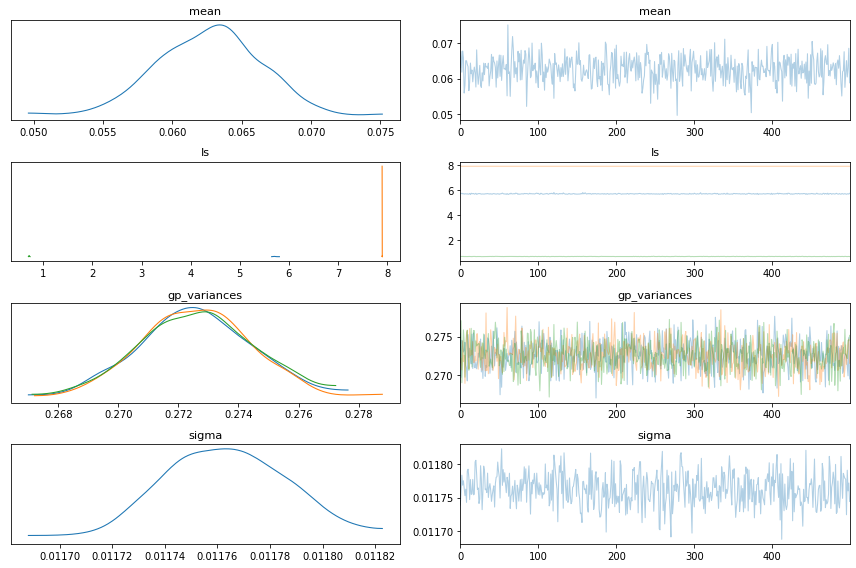

In [23]:
import arviz as az
az.plot_trace(stpk.trace)
plt.tight_layout()

In [13]:
#stpk.trace.to_netcdf('../data/stp_trace.nc');


# Generating predictions at new locations

In [14]:
trace = az.from_netcdf('../data/stp_trace.nc');

In [30]:
from functools import partial
from sklearn.gaussian_process.kernels import Matern

import scipy

def average_point(trace):
    return {k: trace.posterior[k].mean(axis=(0,1)).to_numpy() for k in trace.posterior.keys()}

pt = average_point(trace)

kron_Xs_old = data['sir']['coords_train'].copy()
kron_Xs_new = data['sir']['coords_test'].copy()


noise_sigma = pt['sigma']

# Select only a handful of test param points
kron_Xs_new[-1] = kron_Xs_new[-1][::40]
 
# There was an error in the initial code version
# that used the wrong scale (squared instead of unsquared) in the
# pymc3 model
    
kernels = [variance * Matern(length_scale=ls, nu=2.5) for variance, ls in zip(pt['gp_variances'], pt['ls'])]

crosscov  = [k(old, new) for k, old, new in zip(kernels, kron_Xs_old, kron_Xs_new)]
traincovs = [k(old, old) for k, old in zip(kernels, kron_Xs_old)]

J = len(traincovs)

# Get eigendecompositions for training data
eigen = [scipy.linalg.eigh(A) for A in traincovs]
eigval, eigbasis = zip(*eigen)

lambdas_vec = np.concatenate(eigval)
eigbasis_inv = [scipy.linalg.inv(Q) for Q in eigbasis]

In [31]:
# Apply Kron prod of inverse eigenbases
y = data['sir']['spatiotemporalseries_train']

In [32]:
eigval_array  = eigval[0][:, None, None] * eigval[1][ None,:, None] * eigval[2][None, None, :]
eigval_array += (noise_sigma ** 2) ** (1./J)
eigval_array_inv  = 1./ eigval_array

In [33]:
vec, _ =  mv_einstein(eigbasis_inv, y)
vec    =  eigval_array_inv * vec
vec, _ =  mv_einstein(eigbasis, vec)
vec, _ =  mv_einstein(crosscov, vec)

vec += pt['mean']

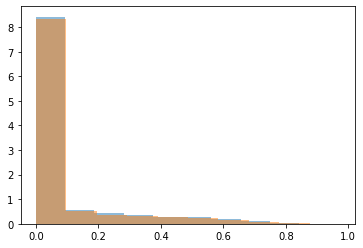

In [34]:
plt.hist(y.ravel(),alpha=0.5, density=True)
plt.hist(data['sir']['spatiotemporalseries_test'].ravel(),alpha=0.5, density=True);

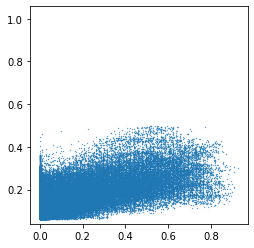

In [36]:
plt.scatter(data['sir']['spatiotemporalseries_test'][...,::40].ravel(), vec.ravel(), s=0.1)
plt.axis('square');

In [21]:
test_vals = data['sir']['spatiotemporalseries_test'][...,::40]

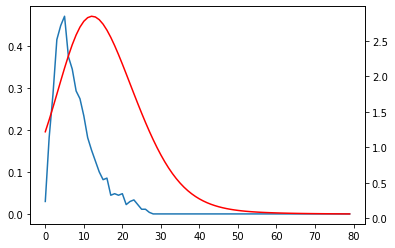

In [22]:
plt.plot(test_vals[-1,:,-10])
twinax = plt.twinx()
twinax.plot(vec[-1,:,-10], color='r')